In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

def process_assets(asset_path):
    assets = []
    for file in os.listdir(asset_path):
        if file.endswith(".png") and file != "_preview.png":
            assets.append(os.path.join(asset_path, file))
    return assets

data = pd.read_csv('../data/performance_filtered.csv')
data = data.head(10)

data['assets'] = data['game_id'].apply(lambda x: process_assets(f'../data/Challenge_Data/Assets/{x}'))
data['preview_image'] = data['game_id'].apply(lambda x: f'../data/Challenge_Data/Assets/{x}/_preview.png')


In [2]:
class AdDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['preview_image']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = AdDataset(data, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [3]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.init_size = 128 // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) 
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Flatten()
        )
        self.adv_layer = nn.Sequential(nn.Linear(32768, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        print(out.shape)  
        validity = self.adv_layer(out)
        return validity


In [4]:
import torch.optim as optim
from torchvision.utils import save_image
import os

latent_dim = 100
lr = 0.0002
b1 = 0.5
b2 = 0.999
epochs = 5000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = nn.BCELoss()

if not os.path.exists('images'):
    os.makedirs('images')

for epoch in range(epochs):
    for i, imgs in enumerate(dataloader):
        
        # Adversarial ground truths
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to(device)

        # Configure input
        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = torch.randn((imgs.size(0), latent_dim)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Save generated images every 500 epochs
        if epoch % 500 == 0:
            save_image(gen_imgs.data[:25], f"images/{epoch}.png", nrow=5, normalize=True)


torch.Size([10, 32768])
torch.Size([10, 32768])
torch.Size([10, 32768])
[Epoch 0/5000] [Batch 0/1] [D loss: 0.6876966953277588] [G loss: 0.6915551424026489]
torch.Size([10, 32768])
torch.Size([10, 32768])
torch.Size([10, 32768])
[Epoch 1/5000] [Batch 0/1] [D loss: 0.6582208871841431] [G loss: 0.6852350831031799]
torch.Size([10, 32768])
torch.Size([10, 32768])
torch.Size([10, 32768])
[Epoch 2/5000] [Batch 0/1] [D loss: 0.6252894997596741] [G loss: 0.6781867742538452]
torch.Size([10, 32768])
torch.Size([10, 32768])
torch.Size([10, 32768])
[Epoch 3/5000] [Batch 0/1] [D loss: 0.5792761445045471] [G loss: 0.6720240116119385]
torch.Size([10, 32768])
torch.Size([10, 32768])
torch.Size([10, 32768])
[Epoch 4/5000] [Batch 0/1] [D loss: 0.5202881693840027] [G loss: 0.664703905582428]
torch.Size([10, 32768])
torch.Size([10, 32768])
torch.Size([10, 32768])
[Epoch 5/5000] [Batch 0/1] [D loss: 0.4618922173976898] [G loss: 0.6554626226425171]
torch.Size([10, 32768])
torch.Size([10, 32768])
torch.Size(

In [5]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))


<All keys matched successfully>

after training our GAN Model what the final product of a highperforming AD looks like, next I'll try to give the model different assts to test if it has learned the composition.

In [1]:
import os
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms

In [2]:
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(latent_dim).to(device)
generator.load_state_dict(torch.load("generator.pth"))
generator.eval()

NameError: name 'Generator' is not defined

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [19]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image

# Function to generate an image using the GAN
def generate_image(generator, latent_dim, device):
    z = torch.randn(1, latent_dim).to(device)
    with torch.no_grad():
        gen_img = generator(z).cpu()
    return gen_img

In [26]:
logo_path = "../data/Challenge_Data/Assets/9e068e03269af51054a95146bdaf3d45/logo.png"
background_path = "../data/Challenge_Data/Assets/9e068e03269af51054a95146bdaf3d45/landing.jpg"
cta_path = "../data/Challenge_Data/Assets/9e068e03269af51054a95146bdaf3d45/cta.jpg"
logo_image = load_image(logo_path)
background_image = load_image(background_path)
cta_image = load_image(cta_path)


In [27]:
# Convert tensors to PIL images for composition
to_pil = transforms.ToPILImage()
logo_image_pil = to_pil(logo_image).convert('RGBA')
background_image_pil = to_pil(background_image).convert('RGBA')
cta_image_pil = to_pil(cta_image).convert('RGBA')

In [28]:
generated_content = generate_image(generator, latent_dim, device)
generated_content_pil = to_pil(generated_content.squeeze(0)).convert('RGBA')

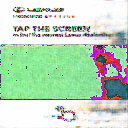

In [31]:
banner_width, banner_height = background_image_pil.size
banner = Image.new('RGB', (banner_width, banner_height))

banner.paste(background_image_pil, (0, 0))

#position desfination
banner_position = (20, 20) 
logo_position = (banner_width - cta_image_pil.width - 20, banner_height - cta_image_pil.height - 20) 
generated_content_position = (banner_width // 2 - generated_content_pil.width // 2, banner_height // 2 - generated_content_pil.height // 2)  # Center

banner.paste(logo_image_pil, logo_position, logo_image_pil)
banner.paste(cta_image_pil, cta_position, cta_image_pil)
banner.paste(generated_content_pil, generated_content_position, generated_content_pil)

banner.save("advertisement_banner.png")

banner.show()

The GAN-generated advertisements did not utilize the provided assets effectively. Instead, the model created ads that mirrored the colors and text styles of the training data but failed to position the specific assets. This occurred because GANs, typically used for data generation, are not inherently equipped to learn and apply specific spatial rules or preferences without labeled data guiding the placement of assets.

Another issues could also be the training data set with filled with a lot of similar ads and the smallness of the dataser